# Portfolio Project: Data Analysis Foundations (Python)

This notebook is a portfolio-style walkthrough of core data analysis workflows:
data generation, cleaning, exploratory analysis, feature engineering, aggregation, and visualization.

To keep this notebook reproducible and self-contained, it uses ** data** with realistic structure and noise.


In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
RNG = np.random.default_rng(42)

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 160)


Matplotlib is building the font cache; this may take a moment.


## 1)  dataset

We simulate a compact retail-like data model:
- `customers`: customer attributes (segment, region, signup date)
- `products`: product catalog (category, base price)
- `orders`: order-level facts (date, customer, channel)
- `order_lines`: line items (product, quantity, unit price, discount)

Then we produce portfolio-ready tables and visuals.


In [2]:
# --- Customers ---
n_customers = 600
customers = pd.DataFrame({
    "customer_id": np.arange(1, n_customers + 1),
    "segment": RNG.choice(["Consumer", "SMB", "Enterprise"], size=n_customers, p=[0.72, 0.23, 0.05]),
    "region": RNG.choice(["North", "South", "East", "West"], size=n_customers),
    "signup_days_ago": RNG.integers(10, 900, size=n_customers),
})
customers["signup_date"] = pd.Timestamp.today().normalize() - pd.to_timedelta(customers["signup_days_ago"], unit="D")
customers.drop(columns=["signup_days_ago"], inplace=True)

print("customers:", customers.shape)
display(customers.head())

# --- Products ---
products = pd.DataFrame({
    "product_id": np.arange(1, 81),
    "category": RNG.choice(["Accessories", "Apparel", "Electronics", "Home"], size=80, p=[0.25, 0.35, 0.25, 0.15]),
})
base_price_map = {"Accessories": 18, "Apparel": 45, "Electronics": 180, "Home": 70}
products["base_price"] = products["category"].map(base_price_map) * RNG.lognormal(mean=0.0, sigma=0.35, size=len(products))
products["base_price"] = products["base_price"].round(2)

print("products:", products.shape)
display(products.head())

# --- Orders ---
n_orders = 5000
order_dates = pd.Timestamp.today().normalize() - pd.to_timedelta(RNG.integers(0, 365, size=n_orders), unit="D")

orders = pd.DataFrame({
    "order_id": np.arange(1, n_orders + 1),
    "order_date": order_dates,
    "customer_id": RNG.choice(customers["customer_id"], size=n_orders),
    "channel": RNG.choice(["Web", "Mobile", "Marketplace"], size=n_orders, p=[0.52, 0.38, 0.10]),
})
orders["order_month"] = orders["order_date"].dt.to_period("M").astype(str)

print("orders:", orders.shape)
display(orders.head())

# --- Order lines ---
items_per_order = RNG.integers(1, 6, size=n_orders)
n_lines = int(items_per_order.sum())

order_lines = pd.DataFrame({
    "order_id": np.repeat(orders["order_id"].values, items_per_order),
    "product_id": RNG.choice(products["product_id"], size=n_lines),
    "quantity": RNG.integers(1, 5, size=n_lines),
})

order_lines = order_lines.merge(products[["product_id", "category", "base_price"]], on="product_id", how="left")

order_lines["unit_price"] = (order_lines["base_price"] * RNG.normal(1.0, 0.12, size=n_lines)).clip(lower=3)
order_lines["unit_price"] = order_lines["unit_price"].round(2)

discount_rate = np.where(
    order_lines["category"].isin(["Apparel", "Accessories"]),
    RNG.uniform(0, 0.25, size=n_lines),
    RNG.uniform(0, 0.15, size=n_lines),
)
order_lines["discount_pct"] = (discount_rate * RNG.choice([0, 1], size=n_lines, p=[0.55, 0.45])).round(3)

order_lines["gross_sales"] = (order_lines["unit_price"] * order_lines["quantity"]).round(2)
order_lines["discount_amount"] = (order_lines["gross_sales"] * order_lines["discount_pct"]).round(2)
order_lines["net_sales"] = (order_lines["gross_sales"] - order_lines["discount_amount"]).round(2)

print("order_lines:", order_lines.shape)
display(order_lines.head())


customers: (600, 4)


,customer_id,segment,region,signup_date
0,1,SMB,West,2025-12-01
1,2,Consumer,South,2024-11-30
2,3,SMB,West,2024-12-12
3,4,Consumer,West,2025-06-04
4,5,Consumer,East,2025-09-29


products: (80, 3)


,product_id,category,base_price
0,1,Apparel,81.12
1,2,Apparel,37.37
2,3,Electronics,259.48
3,4,Electronics,184.33
4,5,Accessories,15.58


orders: (5000, 5)


,order_id,order_date,customer_id,channel,order_month
0,1,2025-12-20,487,Mobile,2025-12
1,2,2025-09-15,17,Mobile,2025-09
2,3,2025-04-17,533,Web,2025-04
3,4,2025-06-19,406,Mobile,2025-06
4,5,2025-12-12,5,Web,2025-12


order_lines: (14929, 10)


,order_id,product_id,quantity,category,base_price,unit_price,discount_pct,gross_sales,discount_amount,net_sales
0,1,16,4,Apparel,44.40,42.72,0.024,170.88,4.10,166.78
1,1,67,4,Accessories,6.81,7.45,0.000,29.80,0.00,29.80
2,1,12,3,Electronics,200.07,225.42,0.120,676.26,81.15,595.11
3,1,36,4,Accessories,31.73,34.95,0.074,139.80,10.35,129.45
4,1,67,4,Accessories,6.81,5.54,0.230,22.16,5.10,17.06


## 2) Analytical table + KPI snapshot

In [3]:
df = (order_lines
      .merge(orders[["order_id", "order_date", "order_month", "customer_id", "channel"]], on="order_id", how="left")
      .merge(customers[["customer_id", "segment", "region", "signup_date"]], on="customer_id", how="left")
)

df["days_since_signup"] = (df["order_date"] - df["signup_date"]).dt.days

print("analytic df:", df.shape)
display(df.head())

kpis = {
    "orders": orders["order_id"].nunique(),
    "customers": customers["customer_id"].nunique(),
    "order_lines": len(df),
    "gross_sales": float(df["gross_sales"].sum()),
    "discount_amount": float(df["discount_amount"].sum()),
    "net_sales": float(df["net_sales"].sum()),
    "avg_order_value_net": float(df.groupby("order_id")["net_sales"].sum().mean()),
}
kpis = pd.Series(kpis).to_frame("value")
display(kpis)


analytic df: (14929, 18)


,order_id,product_id,quantity,category,base_price,unit_price,discount_pct,gross_sales,discount_amount,net_sales,order_date,order_month,customer_id,channel,segment,region,signup_date,days_since_signup
0,1,16,4,Apparel,44.40,42.72,0.024,170.88,4.10,166.78,2025-12-20,2025-12,487,Mobile,Consumer,South,2023-11-06,775
1,1,67,4,Accessories,6.81,7.45,0.000,29.80,0.00,29.80,2025-12-20,2025-12,487,Mobile,Consumer,South,2023-11-06,775
2,1,12,3,Electronics,200.07,225.42,0.120,676.26,81.15,595.11,2025-12-20,2025-12,487,Mobile,Consumer,South,2023-11-06,775
3,1,36,4,Accessories,31.73,34.95,0.074,139.80,10.35,129.45,2025-12-20,2025-12,487,Mobile,Consumer,South,2023-11-06,775
4,1,67,4,Accessories,6.81,5.54,0.230,22.16,5.10,17.06,2025-12-20,2025-12,487,Mobile,Consumer,South,2023-11-06,775


,value
orders,5.000000e+03
customers,6.000000e+02
order_lines,1.492900e+04
gross_sales,2.479672e+06
discount_amount,1.023815e+05
net_sales,2.377290e+06
avg_order_value_net,4.754581e+02


## 3) Visual exploration

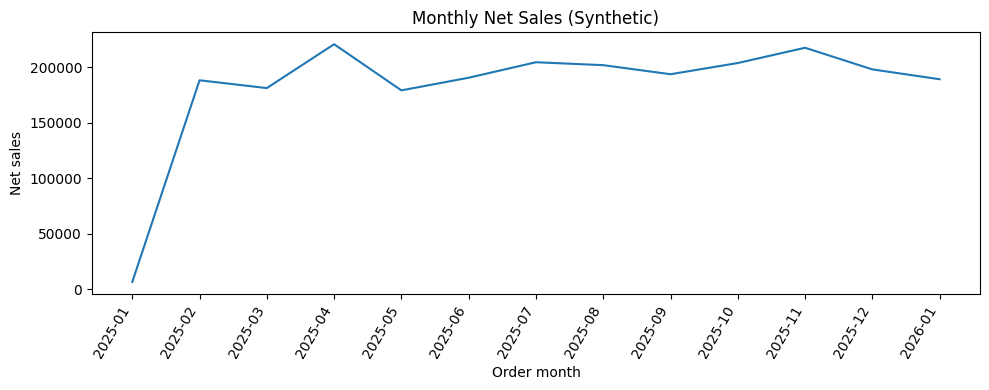

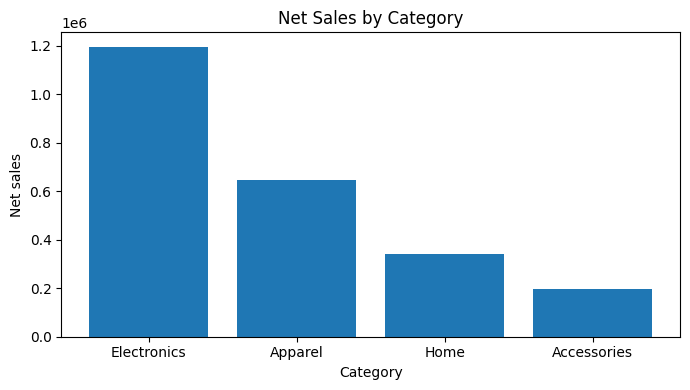

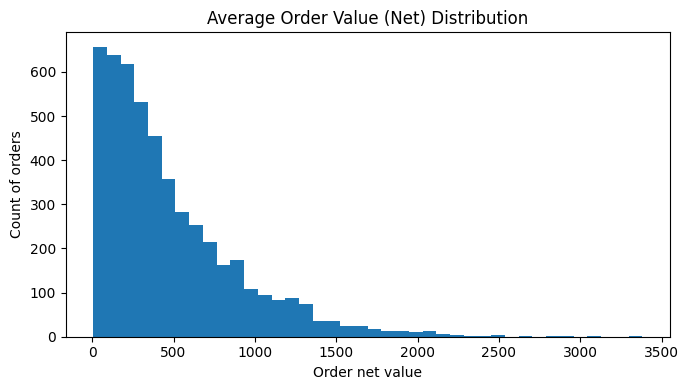

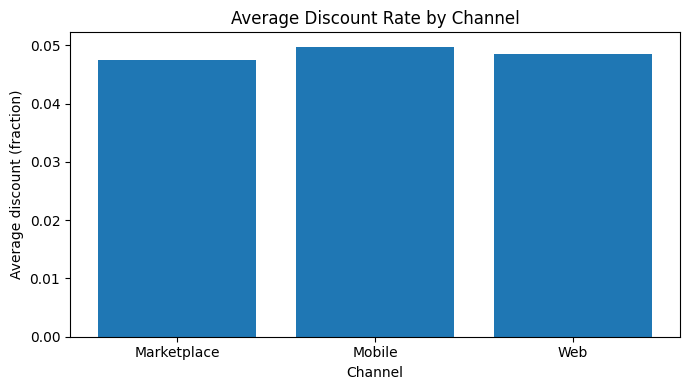

Top 10 orders by net value:


,order_net_sales
order_id,
3691,3381.20
3669,3053.84
2611,2903.92
1395,2808.82
3566,2650.24
2581,2494.08
2484,2492.03
4765,2456.34
4506,2437.55


In [4]:
monthly = df.groupby("order_month", as_index=False)["net_sales"].sum().sort_values("order_month")

plt.figure(figsize=(10, 4))
plt.plot(monthly["order_month"], monthly["net_sales"])
plt.xticks(rotation=60, ha="right")
plt.title("Monthly Net Sales (Synthetic)")
plt.xlabel("Order month")
plt.ylabel("Net sales")
plt.tight_layout()
plt.show()

cat = df.groupby("category", as_index=False)["net_sales"].sum().sort_values("net_sales", ascending=False)

plt.figure(figsize=(7, 4))
plt.bar(cat["category"], cat["net_sales"])
plt.title("Net Sales by Category")
plt.xlabel("Category")
plt.ylabel("Net sales")
plt.tight_layout()
plt.show()

aov = df.groupby("order_id")["net_sales"].sum()

plt.figure(figsize=(7, 4))
plt.hist(aov, bins=40)
plt.title("Average Order Value (Net) Distribution")
plt.xlabel("Order net value")
plt.ylabel("Count of orders")
plt.tight_layout()
plt.show()

disc = df.groupby("channel", as_index=False)["discount_pct"].mean()

plt.figure(figsize=(7, 4))
plt.bar(disc["channel"], disc["discount_pct"])
plt.title("Average Discount Rate by Channel")
plt.xlabel("Channel")
plt.ylabel("Average discount (fraction)")
plt.tight_layout()
plt.show()

print("Top 10 orders by net value:")
display(df.groupby("order_id")["net_sales"].sum().sort_values(ascending=False).head(10).to_frame("order_net_sales"))


## 4) Deeper analysis: RFM-style customer scoring

Customer RFM sample (top scores):


,customer_id,last_order_date,orders,net_sales,recency_days,r_score,f_score,m_score,rfm_score,rfm_segment
300,301,2026-01-26,15,10030.11,4,5,5,5,555,Champions
412,413,2026-01-30,12,8902.11,0,5,5,5,555,Champions
237,238,2026-01-21,11,5633.88,9,5,5,5,555,Champions
155,156,2026-01-21,12,8437.28,9,5,5,5,555,Champions
76,77,2026-01-19,11,6188.87,11,5,5,5,555,Champions
142,143,2026-01-24,15,6304.45,6,5,5,5,555,Champions
285,286,2026-01-21,11,7138.68,9,5,5,5,555,Champions
353,354,2026-01-29,12,8505.36,1,5,5,5,555,Champions
293,294,2026-01-28,14,8421.68,2,5,5,5,555,Champions
93,94,2026-01-26,14,5724.90,4,5,5,5,555,Champions


RFM segment summary:

,rfm_segment,customers,avg_orders,avg_net_sales,avg_recency_days
5,Regular,259,7.583012,3416.916911,42.513514
2,Champions,96,11.437500,5989.468542,9.156250
4,Loyal / Recent,84,8.976190,3729.105952,11.952381
3,Hibernating,72,4.750000,2093.435417,96.013889
0,At Risk (High Frequency),59,10.423729,5153.443729,72.491525
1,At Risk (High Value),30,7.566667,4976.480000,76.933333


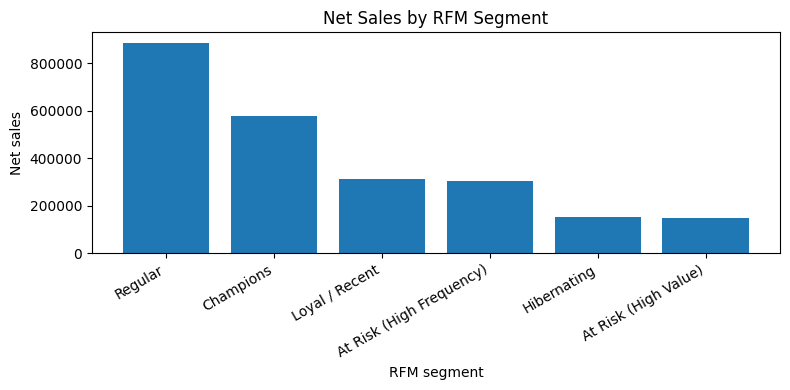

In [5]:
cust_orders = (df.groupby(["customer_id"], as_index=False)
               .agg(
                   last_order_date=("order_date", "max"),
                   orders=("order_id", "nunique"),
                   net_sales=("net_sales", "sum"),
               ))

today = df["order_date"].max()
cust_orders["recency_days"] = (today - cust_orders["last_order_date"]).dt.days

cust_orders["r_score"] = pd.qcut(cust_orders["recency_days"], 5, labels=[5,4,3,2,1]).astype(int)
cust_orders["f_score"] = pd.qcut(cust_orders["orders"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
cust_orders["m_score"] = pd.qcut(cust_orders["net_sales"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

cust_orders["rfm_score"] = cust_orders["r_score"]*100 + cust_orders["f_score"]*10 + cust_orders["m_score"]

def label_rfm(r, f, m):
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if r >= 4 and f >= 3:
        return "Loyal / Recent"
    if r <= 2 and f >= 4:
        return "At Risk (High Frequency)"
    if r <= 2 and m >= 4:
        return "At Risk (High Value)"
    if f == 1 and r <= 2:
        return "Hibernating"
    return "Regular"

cust_orders["rfm_segment"] = [label_rfm(r,f,m) for r,f,m in zip(cust_orders["r_score"], cust_orders["f_score"], cust_orders["m_score"])]

print("Customer RFM sample (top scores):")
display(cust_orders.sort_values("rfm_score", ascending=False).head(12))

seg_summary = cust_orders.groupby("rfm_segment", as_index=False).agg(
    customers=("customer_id", "nunique"),
    avg_orders=("orders", "mean"),
    avg_net_sales=("net_sales", "mean"),
    avg_recency_days=("recency_days", "mean"),
).sort_values("customers", ascending=False)

print("RFM segment summary:")
display(seg_summary)

seg_sales = cust_orders.groupby("rfm_segment")["net_sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(seg_sales.index, seg_sales.values)
plt.xticks(rotation=30, ha="right")
plt.title("Net Sales by RFM Segment")
plt.xlabel("RFM segment")
plt.ylabel("Net sales")
plt.tight_layout()
plt.show()


## 5) Export artifacts

In [6]:
monthly.to_csv("monthly_net_sales.csv", index=False)
cat.to_csv("category_net_sales.csv", index=False)
cust_orders.to_csv("customer_rfm.csv", index=False)

print("Exported files:")
for f in ["monthly_net_sales.csv", "category_net_sales.csv", "customer_rfm.csv"]:
    print(" -", f)


Exported files:
 - monthly_net_sales.csv
 - category_net_sales.csv
 - customer_rfm.csv
